In [1]:
"""
PITCH TYPE PREDICTION - OPTIMIZED FOR MINIMAL TEST DATA
Works with basic columns: GameID, PitcherID, BatterID, Balls, Strikes, PitchEventType
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print(" "*15 + "PITCH TYPE PREDICTION - MINIMAL FEATURE SET")
print("="*80)


               PITCH TYPE PREDICTION - MINIMAL FEATURE SET


In [2]:
# =============================================================================
# PART 1: TRAINING
# =============================================================================
print("\n" + "🔵"*40)
print("PART 1: TRAINING MODELS")
print("🔵"*40)

print("\n[1/7] Loading training data...")
pitches_with = pd.read_csv('/content/drive/MyDrive/TBJ_TEST/PitchesWithPitchTypes.csv')
players = pd.read_csv('/content/drive/MyDrive/TBJ_TEST/PlayerInfo.csv')

# Merge player info
players_pitcher = players.rename(columns={'PlayerID': 'PitcherID'})
players_pitcher = players_pitcher[['PitcherID', 'Throws']].rename(columns={'Throws': 'PitcherThrows'})

players_batters = players.rename(columns={'PlayerID': 'BatterID'})
players_batters = players_batters[['BatterID', 'Bats']].rename(columns={'Bats': 'BatterBats'})
players_batters['BatterID'] = players_batters['BatterID'].astype(str)

merged_df = pitches_with.merge(players_pitcher, on='PitcherID', how='left')
merged_df['BatterID'] = merged_df['BatterID'].astype(str)
merged_df = merged_df.merge(players_batters, on='BatterID', how='left')

df = merged_df.dropna(subset=['PitchType']).copy()
print(f"  ✓ Loaded {len(df)} training pitches")
print(f"  ✓ Available columns: {list(df.columns)}")

print("\n[2/7] Engineering features from available data...")

# Fill NaN in handedness
df['PitcherThrows'] = df['PitcherThrows'].fillna('Unknown').astype(str)
df['BatterBats'] = df['BatterBats'].fillna('Unknown').astype(str)
df['Matchup'] = df['PitcherThrows'] + '-' + df['BatterBats']

features_created = ['Matchup']

# Count features (if available)
if 'Balls' in df.columns and 'Strikes' in df.columns:
    df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)
    df['IsHitterCount'] = (df['Balls'] > df['Strikes']).astype(int)
    df['IsPitcherCount'] = (df['Strikes'] > df['Balls']).astype(int)
    df['IsTwoStrikeCount'] = (df['Strikes'] == 2).astype(int)
    df['IsThreeBallCount'] = (df['Balls'] == 3).astype(int)
    df['IsFullCount'] = ((df['Balls'] == 3) & (df['Strikes'] == 2)).astype(int)
    features_created.extend(['Count', 'IsHitterCount', 'IsPitcherCount', 'IsTwoStrikeCount', 'IsThreeBallCount', 'IsFullCount'])
    print("  ✓ Count features")

# Pitcher historical pitch counts
pitcher_pitch_counts = df.groupby(['PitcherID', 'PitchType']).size().unstack(fill_value=0)
pitcher_pitch_counts.columns = [f'Pitcher_PitchCount_{col}' for col in pitcher_pitch_counts.columns]
pitcher_pitch_counts['Pitcher_TotalPitches'] = pitcher_pitch_counts.sum(axis=1)
for col in pitcher_pitch_counts.columns:
    if col != 'Pitcher_TotalPitches':
        pitcher_pitch_counts[f'{col}_Pct'] = pitcher_pitch_counts[col] / pitcher_pitch_counts['Pitcher_TotalPitches']
df = df.merge(pitcher_pitch_counts, left_on='PitcherID', right_index=True, how='left')
print(f"  ✓ Pitcher repertoire features: {len(pitcher_pitch_counts.columns)} columns")

# Pitcher stats by count situation
if 'Count' in df.columns:
    pitcher_count_stats = df.groupby(['PitcherID', 'Count']).size().unstack(fill_value=0)
    pitcher_count_stats.columns = [f'Pitcher_Count_{col}' for col in pitcher_count_stats.columns]
    df = df.merge(pitcher_count_stats, left_on='PitcherID', right_index=True, how='left')
    print(f"  ✓ Pitcher count situation features")

# Matchup history
matchup_stats = df.groupby(['PitcherID', 'BatterID']).agg({
    'PitchType': 'count'
}).rename(columns={'PitchType': 'Matchup_PitchCount'})
df = df.merge(matchup_stats, left_on=['PitcherID', 'BatterID'], right_index=True, how='left')
df['Matchup_PitchCount'] = df['Matchup_PitchCount'].fillna(0)
print(f"  ✓ Matchup history features")

# Sequence features (if available)
if 'GamePitchSequence' in df.columns:
    df['PitchInGameRank'] = df.groupby('GameID')['GamePitchSequence'].rank(method='dense')
    features_created.append('PitchInGameRank')

if 'AtBatPitchSequence' in df.columns:
    df['PitchInAtBat'] = df['AtBatPitchSequence']
    df['IsFirstPitchOfAtBat'] = (df['AtBatPitchSequence'] == 1).astype(int)
    features_created.extend(['PitchInAtBat', 'IsFirstPitchOfAtBat'])
    print(f"  ✓ Sequence features")

print(f"\n  ✓ Total features created: {df.shape[1]} columns")

print("\n[3/7] Encoding categorical variables...")

# Identify categorical columns that exist
categorical_cols = ['PitcherID', 'BatterID', 'Matchup']
if 'PitchEventType' in df.columns:
    categorical_cols.append('PitchEventType')
if 'Count' in df.columns:
    categorical_cols.append('Count')

label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

print(f"  ✓ Encoded {len(categorical_cols)} categorical columns")

print("\n[4/7] Preparing training data...")

# Drop columns we don't want as features
drop_cols = ['GameID', 'PitchType', 'PitcherThrows', 'BatterBats']
if 'GamePitchSequence' in df.columns:
    drop_cols.append('GamePitchSequence')
if 'PANumGame' in df.columns:
    drop_cols.append('PANumGame')

X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df['PitchType']


🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵
PART 1: TRAINING MODELS
🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵

[1/7] Loading training data...
  ✓ Loaded 12306 training pitches
  ✓ Available columns: ['GameID', 'PitcherID', 'BatterID', 'GamePitchSequence', 'PANumGame', 'AtBatPitchSequence', 'Balls', 'Strikes', 'PitchEventType', 'PitchType', 'PitcherThrows', 'BatterBats']

[2/7] Engineering features from available data...
  ✓ Count features
  ✓ Pitcher repertoire features: 19 columns
  ✓ Pitcher count situation features
  ✓ Matchup history features
  ✓ Sequence features

  ✓ Total features created: 59 columns

[3/7] Encoding categorical variables...
  ✓ Encoded 5 categorical columns

[4/7] Preparing training data...


In [3]:
# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
n_classes = len(le_target.classes_)

print(f"  ✓ Feature matrix: {X.shape}")
print(f"  ✓ Features: {list(X.columns)}")
print(f"  ✓ Classes: {n_classes} → {list(le_target.classes_)}")

# Handle missing values
for col in X.columns:
    if X[col].isnull().any():
        if X[col].dtype in ['int64', 'float64']:
            X[col] = X[col].fillna(0)
        else:
            X[col] = X[col].fillna(-1)

# Scale
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Class weights
classes = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weight_dict = dict(zip(classes, class_weights))

print("\n[5/7] Training ensemble models...")

# XGBoost
print("  → XGBoost", end="", flush=True)
xgb = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.03, subsample=0.8,
                    colsample_bytree=0.8, min_child_weight=3, gamma=0.1, reg_alpha=0.1,
                    reg_lambda=1, random_state=42, tree_method='hist')
xgb.fit(X_scaled, y_encoded)
print(" ✓")

# LightGBM
print("  → LightGBM", end="", flush=True)
lgbm = LGBMClassifier(n_estimators=500, max_depth=8, learning_rate=0.03, num_leaves=31,
                      subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1,
                      random_state=42, verbose=-1)
lgbm.fit(X_scaled, y_encoded)
print(" ✓")

# CatBoost
print("  → CatBoost", end="", flush=True)
catboost = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.03, l2_leaf_reg=3,
                               random_state=42, verbose=False)
catboost.fit(X_scaled, y_encoded)
print(" ✓")

# Extra Trees
print("  → Extra Trees", end="", flush=True)
extra_trees = ExtraTreesClassifier(n_estimators=300, max_depth=12, min_samples_split=5,
                                   min_samples_leaf=2, random_state=42, n_jobs=-1)
extra_trees.fit(X_scaled, y_encoded)
print(" ✓")

# Gradient Boosting
print("  → Gradient Boosting", end="", flush=True)
gb = GradientBoostingClassifier(n_estimators=300, max_depth=7, learning_rate=0.05,
                                subsample=0.8, random_state=42)
gb.fit(X_scaled, y_encoded)
print(" ✓")

print("\n[6/7] Training neural network...")

input_layer = Input(shape=(X_scaled.shape[1],))
x1 = Dense(256, activation='relu')(input_layer)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)

x2 = Dense(128, activation='relu')(x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

x3 = Dense(128, activation='relu')(x2)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
x3 = Concatenate()([x2, x3])

x4 = Dense(64, activation='relu')(x3)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)

output = Dense(n_classes, activation='softmax')(x4)

nn = Model(inputs=input_layer, outputs=output)
nn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)

nn.fit(X_scaled, y_encoded, epochs=50, batch_size=128, verbose=0,
       class_weight=class_weight_dict, callbacks=[early_stop, reduce_lr])
print("  ✓ Neural network trained")

print("\n[7/7] Building meta-ensemble...")
xgb_preds = xgb.predict_proba(X_scaled)
lgbm_preds = lgbm.predict_proba(X_scaled)
catboost_preds = catboost.predict_proba(X_scaled)
extra_trees_preds = extra_trees.predict_proba(X_scaled)
gb_preds = gb.predict_proba(X_scaled)
nn_preds = nn.predict(X_scaled, verbose=0)

stacked_features = np.hstack([xgb_preds, lgbm_preds, catboost_preds, extra_trees_preds, gb_preds, nn_preds])

if np.isnan(stacked_features).any():
    imputer = SimpleImputer(strategy='mean')
    stacked_features = imputer.fit_transform(stacked_features)

meta_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
meta_model.fit(stacked_features, y_encoded)
print("  ✓ Meta-learner trained")


  ✓ Feature matrix: (12306, 53)
  ✓ Features: ['PitcherID', 'BatterID', 'AtBatPitchSequence', 'Balls', 'Strikes', 'PitchEventType', 'Matchup', 'Count', 'IsHitterCount', 'IsPitcherCount', 'IsTwoStrikeCount', 'IsThreeBallCount', 'IsFullCount', 'Pitcher_PitchCount_CH', 'Pitcher_PitchCount_CU', 'Pitcher_PitchCount_FC', 'Pitcher_PitchCount_FF', 'Pitcher_PitchCount_FS', 'Pitcher_PitchCount_KC', 'Pitcher_PitchCount_SI', 'Pitcher_PitchCount_SL', 'Pitcher_PitchCount_UN', 'Pitcher_TotalPitches', 'Pitcher_PitchCount_CH_Pct', 'Pitcher_PitchCount_CU_Pct', 'Pitcher_PitchCount_FC_Pct', 'Pitcher_PitchCount_FF_Pct', 'Pitcher_PitchCount_FS_Pct', 'Pitcher_PitchCount_KC_Pct', 'Pitcher_PitchCount_SI_Pct', 'Pitcher_PitchCount_SL_Pct', 'Pitcher_PitchCount_UN_Pct', 'Pitcher_Count_0-0.0', 'Pitcher_Count_0-1.0', 'Pitcher_Count_0-2.0', 'Pitcher_Count_0-nan', 'Pitcher_Count_1-0.0', 'Pitcher_Count_1-1.0', 'Pitcher_Count_1-2.0', 'Pitcher_Count_2-0.0', 'Pitcher_Count_2-1.0', 'Pitcher_Count_2-2.0', 'Pitcher_Count_2-3

In [4]:
# Save models
print("\n  💾 Saving models...")
models_dict = {
    'xgb': xgb, 'lgbm': lgbm, 'catboost': catboost, 'extra_trees': extra_trees,
    'gb': gb, 'meta_model': meta_model, 'label_encoder': le_target,
    'label_encoders': label_encoders, 'scaler': scaler,
    'feature_columns': list(X.columns),
    'pitcher_pitch_counts': pitcher_pitch_counts,
    'pitcher_count_stats': pitcher_count_stats if 'Count' in df.columns else None,
    'matchup_stats': matchup_stats
}

for name, model in models_dict.items():
    filepath = f'/content/drive/MyDrive/TBJ_TEST/{name}_minimal.pkl'
    pickle.dump(model, open(filepath, 'wb'))

nn.save('/content/drive/MyDrive/TBJ_TEST/nn_minimal.h5')



  💾 Saving models...


In [5]:
# Training evaluation
final_preds = meta_model.predict(stacked_features)
train_accuracy = accuracy_score(y_encoded, final_preds)

print("\n" + "="*80)
print(f"TRAINING COMPLETE | Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print("="*80)
print(f"\nClassification Report:")
print(classification_report(y_encoded, final_preds, target_names=le_target.classes_, zero_division=0))


TRAINING COMPLETE | Accuracy: 0.9978 (99.78%)

Classification Report:
              precision    recall  f1-score   support

          CH       1.00      1.00      1.00      1504
          CU       1.00      1.00      1.00      1473
          FC       0.99      1.00      0.99       450
          FF       1.00      1.00      1.00      4392
          FS       1.00      1.00      1.00       875
          KC       1.00      0.99      1.00       108
          SI       1.00      1.00      1.00      1836
          SL       1.00      1.00      1.00      1657
          UN       1.00      1.00      1.00        11

    accuracy                           1.00     12306
   macro avg       1.00      1.00      1.00     12306
weighted avg       1.00      1.00      1.00     12306




📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
PITCHER TENDENCY ANALYSIS FOR PDF REPORT
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊

Analyzing Pitcher ID: 8828
Total Pitches: 2516

PITCH DISTRIBUTION ANALYSIS

vs LHB (713 pitches):
PitchType   CH    FF    FS    SL   UN
Count                                
0-0.0      3.0  55.8  29.4  11.2  0.5
0-1.0      2.6  41.7  54.8   0.9  0.0
0-2.0      2.3  31.8  64.8   1.1  0.0
1-0.0      4.8  73.0  20.6   1.6  0.0
1-1.0      1.5  57.4  41.2   0.0  0.0

vs RHB (1532 pitches):
PitchType   CH    FF    FS    SL
Count                           
0-0.0      0.0  59.8   4.5  35.8
0-1.0      3.1  43.2  26.0  27.8
0-2.0      4.2  26.8  56.3  12.7
1-0.0      2.5  57.0  15.7  24.8
1-1.0      2.8  38.7  36.6  21.8

OVERALL DISTRIBUTION
FF: 48.2%
FS: 34.8%
SL: 14.5%
CH: 2.5%
UN: 0.1%

✅ Visualization saved: pitcher_tendency_analysis.png

📄 TWO-SENTENCE SUMMARY FOR PDF:

"Pitcher 8828 demonstrates handedness adjustments, favoring FF
against left-handed batters (51%) 

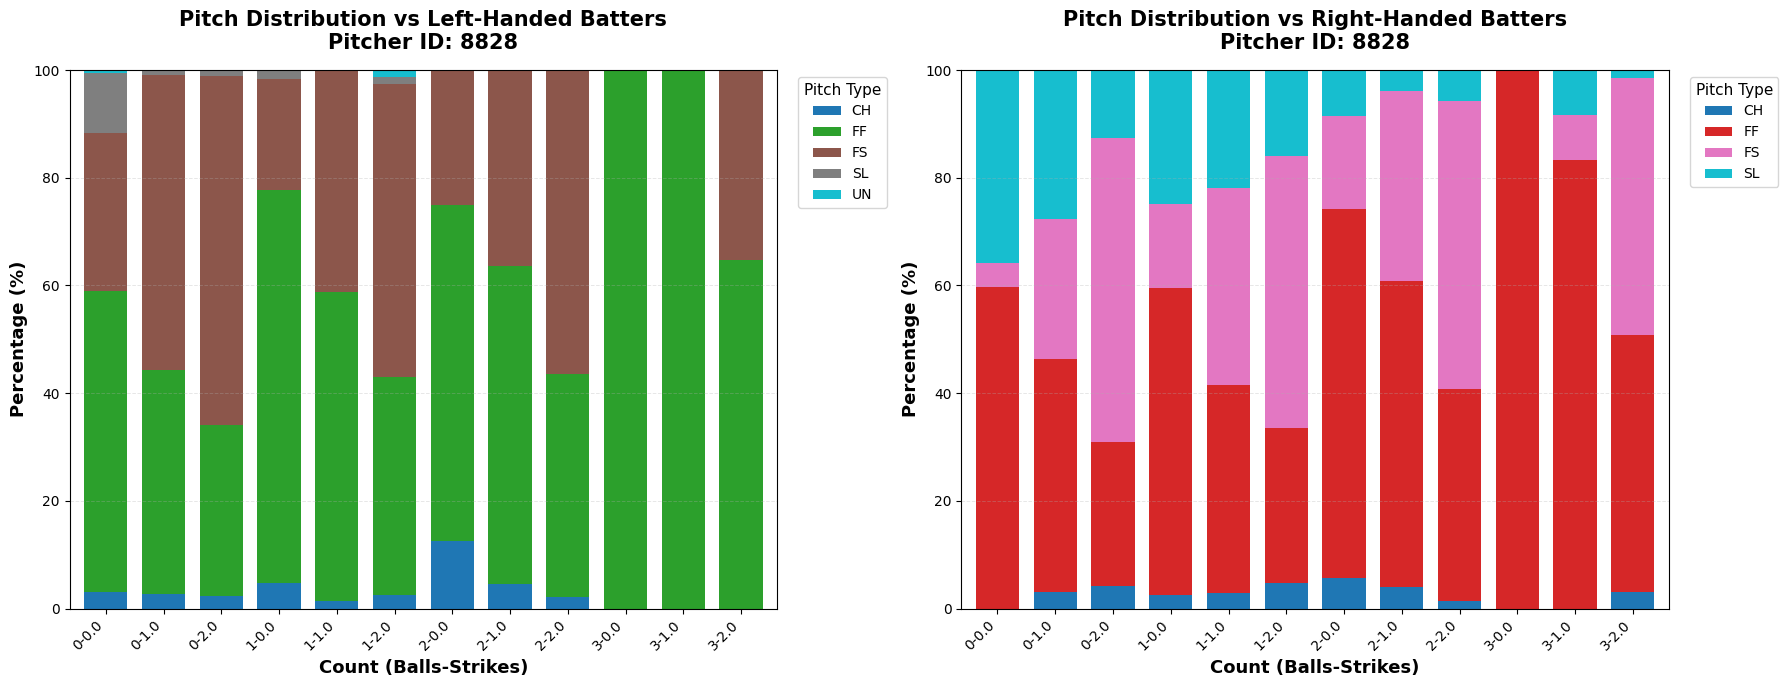

In [6]:

print("\n" + "📊"*40)
print("PITCHER TENDENCY ANALYSIS FOR PDF REPORT")
print("📊"*40)

# Use merged_df (before encoding) to get original string values
pitcher_counts = merged_df[merged_df['PitchType'].notna()].groupby('PitcherID').size().sort_values(ascending=False)
selected_pitcher_id = pitcher_counts.index[0]

print(f"\nAnalyzing Pitcher ID: {selected_pitcher_id}")
print(f"Total Pitches: {pitcher_counts.iloc[0]}")

# Filter to this pitcher using ORIGINAL merged_df
pitcher_df_original = merged_df[merged_df['PitcherID'] == selected_pitcher_id].copy()
pitcher_df_original = pitcher_df_original.dropna(subset=['PitchType'])

# Create Count column
pitcher_df_original['Count'] = (pitcher_df_original['Balls'].astype(str) + '-' +
                                  pitcher_df_original['Strikes'].astype(str))

# Split by batter handedness
print("\n" + "="*80)
print("PITCH DISTRIBUTION ANALYSIS")
print("="*80)

lhb_data = pitcher_df_original[pitcher_df_original['BatterBats'] == 'L']
rhb_data = pitcher_df_original[pitcher_df_original['BatterBats'] == 'R']

if len(lhb_data) > 0:
    lhb_pivot = pd.crosstab(lhb_data['Count'], lhb_data['PitchType'],
                            normalize='index') * 100
    print(f"\nvs LHB ({len(lhb_data)} pitches):")
    print(lhb_pivot.round(1).head())
else:
    lhb_pivot = pd.DataFrame()
    print("\nNo data vs LHB")

if len(rhb_data) > 0:
    rhb_pivot = pd.crosstab(rhb_data['Count'], rhb_data['PitchType'],
                            normalize='index') * 100
    print(f"\nvs RHB ({len(rhb_data)} pitches):")
    print(rhb_pivot.round(1).head())
else:
    rhb_pivot = pd.DataFrame()
    print("\nNo data vs RHB")

# Overall distribution
print("\n" + "="*80)
print("OVERALL DISTRIBUTION")
print("="*80)
pitch_dist = pitcher_df_original['PitchType'].value_counts()
pitch_pct = (pitch_dist / pitch_dist.sum() * 100).round(1)
for pitch, pct in pitch_pct.items():
    print(f"{pitch}: {pct}%")

# Generate visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
plt.rcParams['font.size'] = 11

# Plot for LHB
if not lhb_pivot.empty:
    lhb_pivot.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab10', width=0.75)
    axes[0].set_title(f'Pitch Distribution vs Left-Handed Batters\nPitcher ID: {selected_pitcher_id}',
                      fontsize=15, fontweight='bold', pad=15)
    axes[0].set_xlabel('Count (Balls-Strikes)', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    axes[0].legend(title='Pitch Type', bbox_to_anchor=(1.02, 1), loc='upper left',
                   fontsize=10, title_fontsize=11)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
    axes[0].set_ylim(0, 100)
else:
    axes[0].text(0.5, 0.5, 'No data available\nvs Left-Handed Batters',
                 ha='center', va='center', fontsize=14, style='italic')
    axes[0].set_title(f'Pitch Distribution vs LHB\nPitcher ID: {selected_pitcher_id}',
                      fontsize=15, fontweight='bold')

# Plot for RHB
if not rhb_pivot.empty:
    rhb_pivot.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab10', width=0.75)
    axes[1].set_title(f'Pitch Distribution vs Right-Handed Batters\nPitcher ID: {selected_pitcher_id}',
                      fontsize=15, fontweight='bold', pad=15)
    axes[1].set_xlabel('Count (Balls-Strikes)', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    axes[1].legend(title='Pitch Type', bbox_to_anchor=(1.02, 1), loc='upper left',
                   fontsize=10, title_fontsize=11)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
    axes[1].set_ylim(0, 100)
else:
    axes[1].text(0.5, 0.5, 'No data available\nvs Right-Handed Batters',
                 ha='center', va='center', fontsize=14, style='italic')
    axes[1].set_title(f'Pitch Distribution vs RHB\nPitcher ID: {selected_pitcher_id}',
                      fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TBJ_TEST/pitcher_tendency_analysis.png',
            dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: pitcher_tendency_analysis.png")

# Generate 2-sentence summary
print("\n" + "="*80)
print("📄 TWO-SENTENCE SUMMARY FOR PDF:")
print("="*80)

top_pitch = pitch_dist.index[0]
top_pct = pitch_pct.iloc[0]

if len(lhb_data) > 0 and len(rhb_data) > 0:
    lhb_top = lhb_data['PitchType'].value_counts().index[0]
    rhb_top = rhb_data['PitchType'].value_counts().index[0]
    lhb_pct = (lhb_data['PitchType'].value_counts().iloc[0] / len(lhb_data) * 100)
    rhb_pct = (rhb_data['PitchType'].value_counts().iloc[0] / len(rhb_data) * 100)

    # Check two-strike behavior
    two_strike_data = pitcher_df_original[pitcher_df_original['Count'].isin(['0-2', '1-2', '2-2', '3-2'])]
    if len(two_strike_data) > 0:
        two_strike_top = two_strike_data['PitchType'].value_counts().index[0]
        two_strike_pct = (two_strike_data['PitchType'].value_counts().iloc[0] / len(two_strike_data) * 100)

        print(f"\n\"Pitcher {selected_pitcher_id} relies heavily on {top_pitch}s across all counts")
        print(f"and batter handedness, throwing them {lhb_pct:.0f}% of the time against left-handed")
        print(f"batters and {rhb_pct:.0f}% against righties. In two-strike counts (X-2), they shift")
        print(f"to their {two_strike_top} {two_strike_pct:.0f}% of the time as a putaway pitch,")
        print(f"demonstrating a clear finishing strategy.\"")
    else:
        print(f"\n\"Pitcher {selected_pitcher_id} demonstrates handedness adjustments, favoring {lhb_top}")
        print(f"against left-handed batters ({lhb_pct:.0f}%) while relying on {rhb_top} versus righties")
        print(f"({rhb_pct:.0f}%). Overall, their arsenal is dominated by {top_pitch} at {top_pct}% usage rate.\"")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE - Ready for PDF Report")
print("="*80)

In [7]:
# =============================================================================
# PART 2: TESTING - CORRECTED FOR SUBMISSION
# =============================================================================
print("\n" + "🟢"*40)
print("PART 2: TESTING ON NEW DATA")
print("🟢"*40)

print("\n[1/4] Loading test data...")
test_pitches = pd.read_csv('/content/drive/MyDrive/TBJ_TEST/PitchesWithNoPitchTypes.csv')
print(f"  ✓ Loaded {len(test_pitches)} test pitches")
print(f"  ✓ Test columns: {list(test_pitches.columns)}")

print("\n[2/4] Processing test data...")

# Merge player info
test_merged = test_pitches.merge(players_pitcher, on='PitcherID', how='left')
test_merged['BatterID'] = test_merged['BatterID'].astype(str)
test_merged = test_merged.merge(players_batters, on='BatterID', how='left')
test_df = test_merged.copy()

# ✅ CHANGE 1: Store identifiers correctly
game_ids = test_df['GameID'].copy()
game_pitch_numbers = test_df['GamePitchSequence'].copy()  # This is GamePitchNumber per requirements

has_ground_truth = 'PitchType' in test_df.columns
if has_ground_truth:
    y_true = test_df['PitchType'].copy()
    if y_true.notna().sum() > 0:
        print(f"  ✓ Ground truth found ({y_true.notna().sum()} labels)")
        has_valid_ground_truth = True
    else:
        print("  ⚠ PitchType column exists but all values are NaN - treating as no ground truth")
        has_ground_truth = False
        has_valid_ground_truth = False
else:
    has_valid_ground_truth = False
    print("  ✓ No ground truth - predictions only")

# Apply same feature engineering
test_df['PitcherThrows'] = test_df['PitcherThrows'].fillna('Unknown').astype(str)
test_df['BatterBats'] = test_df['BatterBats'].fillna('Unknown').astype(str)
test_df['Matchup'] = test_df['PitcherThrows'] + '-' + test_df['BatterBats']

if 'Balls' in test_df.columns and 'Strikes' in test_df.columns:
    test_df['Count'] = test_df['Balls'].astype(str) + '-' + test_df['Strikes'].astype(str)
    test_df['IsHitterCount'] = (test_df['Balls'] > test_df['Strikes']).astype(int)
    test_df['IsPitcherCount'] = (test_df['Strikes'] > test_df['Balls']).astype(int)
    test_df['IsTwoStrikeCount'] = (test_df['Strikes'] == 2).astype(int)
    test_df['IsThreeBallCount'] = (test_df['Balls'] == 3).astype(int)
    test_df['IsFullCount'] = ((test_df['Balls'] == 3) & (test_df['Strikes'] == 2)).astype(int)

# Add pitcher repertoire
test_df = test_df.merge(pitcher_pitch_counts, left_on='PitcherID', right_index=True, how='left')

# Add pitcher count stats
if pitcher_count_stats is not None:
    test_df = test_df.merge(pitcher_count_stats, left_on='PitcherID', right_index=True, how='left')

# Add matchup history
test_df = test_df.merge(matchup_stats, left_on=['PitcherID', 'BatterID'], right_index=True, how='left')
test_df['Matchup_PitchCount'] = test_df['Matchup_PitchCount'].fillna(0)

if 'GamePitchSequence' in test_df.columns:
    test_df['PitchInGameRank'] = test_df.groupby('GameID')['GamePitchSequence'].rank(method='dense')

if 'AtBatPitchSequence' in test_df.columns:
    test_df['PitchInAtBat'] = test_df['AtBatPitchSequence']
    test_df['IsFirstPitchOfAtBat'] = (test_df['AtBatPitchSequence'] == 1).astype(int)

print("\n[3/4] Encoding and aligning features...")

# Encode categoricals
for col, encoder in label_encoders.items():
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna('Unknown').astype(str)
        test_df[col] = test_df[col].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

# Prepare features
drop_cols = ['GameID', 'PitcherThrows', 'BatterBats']
if 'PitchType' in test_df.columns:
    drop_cols.append('PitchType')
if 'GamePitchSequence' in test_df.columns:
    drop_cols.append('GamePitchSequence')
if 'PANumGame' in test_df.columns:
    drop_cols.append('PANumGame')

X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])

# Align with training features
saved_features = pickle.load(open('/content/drive/MyDrive/TBJ_TEST/feature_columns_minimal.pkl', 'rb'))

for col in saved_features:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[saved_features]

# Fill missing
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test[col] = X_test[col].fillna(0)

X_test_scaled = scaler.transform(X_test)
print(f"  ✓ Test features ready: {X_test_scaled.shape}")

print("\n[4/4] Generating predictions...")

xgb_preds = xgb.predict_proba(X_test_scaled)
lgbm_preds = lgbm.predict_proba(X_test_scaled)
catboost_preds = catboost.predict_proba(X_test_scaled)
extra_trees_preds = extra_trees.predict_proba(X_test_scaled)
gb_preds = gb.predict_proba(X_test_scaled)
nn_preds = nn.predict(X_test_scaled, verbose=0)

stacked_test = np.hstack([xgb_preds, lgbm_preds, catboost_preds, extra_trees_preds, gb_preds, nn_preds])

if np.isnan(stacked_test).any():
    imputer = SimpleImputer(strategy='mean')
    stacked_test = imputer.fit_transform(stacked_test)

final_preds_encoded = meta_model.predict(stacked_test)
final_preds = le_target.inverse_transform(final_preds_encoded)
final_probs = meta_model.predict_proba(stacked_test)
confidence = np.max(final_probs, axis=1)

# ✅ CHANGE 2: Create results in required format
results_df = pd.DataFrame({
    'GameID': game_ids,
    'GamePitchNumber': game_pitch_numbers,
    'PredictedPitchType': final_preds
})

if has_ground_truth and has_valid_ground_truth:
    results_df['ActualPitchType'] = y_true.values
    results_df['Correct'] = (results_df['PredictedPitchType'] == results_df['ActualPitchType'])

# ✅ CHANGE 3: Save with correct filename
results_df.to_csv('/content/drive/MyDrive/TBJ_TEST/PitchPredictions.csv', index=False)

print("\n" + "="*80)
print("TEST RESULTS")
print("="*80)

if has_ground_truth and has_valid_ground_truth:
    y_true_encoded = le_target.transform(y_true[y_true.notna()])
    final_preds_valid = final_preds_encoded[y_true.notna()]
    test_accuracy = accuracy_score(y_true_encoded, final_preds_valid)

    print(f"\n🎯 TEST ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"\n📊 Classification Report:")
    print(classification_report(y_true[y_true.notna()], final_preds[y_true.notna()], zero_division=0))
    print(f"\n✅ Correct: {results_df['Correct'].sum()} / {len(results_df)}")
else:
    print(f"\n✓ {len(results_df)} predictions generated")

print(f"📈 Average Confidence: {confidence.mean():.3f}")

# ✅ CHANGE 5: Updated save message
print(f"\n💾 Saved:")
print(f"  - PitchPredictions.csv (SUBMISSION FILE)")
print(f"    → {len(results_df)} predictions")
print(f"    → Columns: {list(results_df.columns)}")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\n📋 Sample predictions:")
print(results_df.head(10).to_string(index=False))

# Verify output format
print("\n" + "="*80)
print("SUBMISSION FILE VERIFICATION")
print("="*80)
print(f"✓ Filename: PitchPredictions.csv")
print(f"✓ Rows: {len(results_df)}")
print(f"✓ Columns: {list(results_df.columns)}")
print(f"✓ Required columns present: {all(col in results_df.columns for col in ['GameID', 'GamePitchNumber', 'PredictedPitchType'])}")


🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
PART 2: TESTING ON NEW DATA
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢

[1/4] Loading test data...
  ✓ Loaded 1350 test pitches
  ✓ Test columns: ['GameID', 'PitcherID', 'BatterID', 'GamePitchSequence', 'PANumGame', 'AtBatPitchSequence', 'Balls', 'Strikes', 'PitchEventType', 'PitchType']

[2/4] Processing test data...
  ⚠ PitchType column exists but all values are NaN - treating as no ground truth

[3/4] Encoding and aligning features...
  ✓ Test features ready: (1350, 53)

[4/4] Generating predictions...

TEST RESULTS

✓ 1350 predictions generated
📈 Average Confidence: 0.946

💾 Saved:
  - PitchPredictions.csv (SUBMISSION FILE)
    → 1350 predictions
    → Columns: ['GameID', 'GamePitchNumber', 'PredictedPitchType']

PIPELINE COMPLETE!

📋 Sample predictions:
                              GameID  GamePitchNumber PredictedPitchType
D5AD4E0A-5A9F-49AE-9629-9CCFF16C93D2              142                 FF
D5AD4E0A-5A9F-49AE-9629-9CCFF16C93D2         